In [30]:
# This program uses Long Short Term Memory (LSTM) to predict the closing stock price of Tesla
# using the last 60 day stock price

#Importing Libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [31]:
#Get the stock quote from yahoo
dataf = web.DataReader('TSLA', data_source='yahoo', start='2015-01-01', end='2020-12-15')
#Show the data
dataf

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,44.650002,42.652000,44.574001,43.862000,23822000.0,43.862000
2015-01-05,43.299999,41.431999,42.910000,42.018002,26842500.0,42.018002
2015-01-06,42.840000,40.841999,42.012001,42.256001,31309500.0,42.256001
2015-01-07,42.956001,41.956001,42.669998,42.189999,14842000.0,42.189999
2015-01-08,42.759998,42.001999,42.562000,42.124001,17212500.0,42.124001
...,...,...,...,...,...,...
2020-12-09,654.320007,588.000000,653.690002,604.479980,71291200.0,604.479980
2020-12-10,627.750000,566.340027,574.369995,627.070007,67083200.0,627.070007
2020-12-11,624.000000,596.799988,615.010010,609.989990,46475000.0,609.989990


In [32]:
#Collect the number of rows and columns from the data set
dataf.shape

(1500, 6)

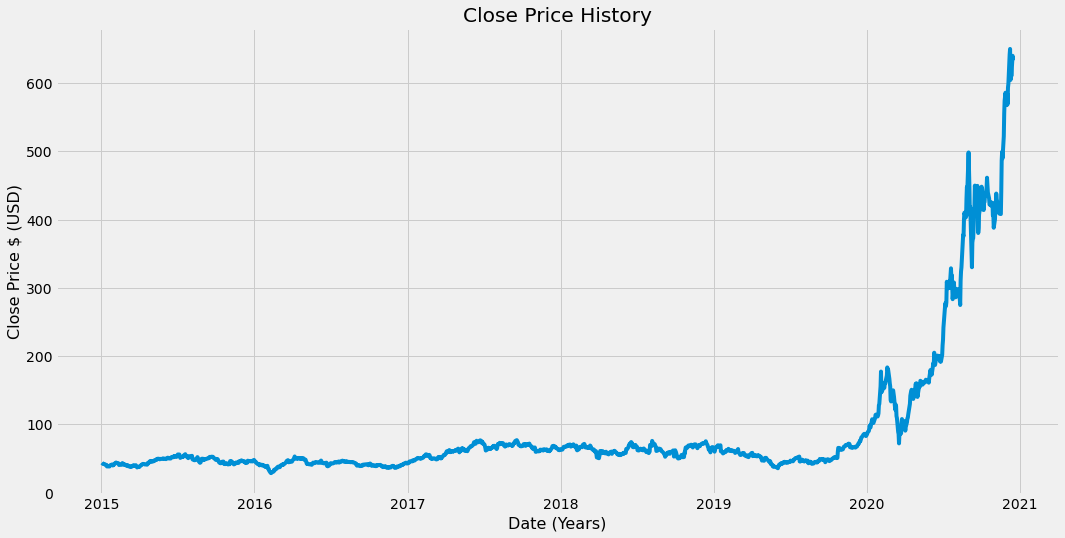

In [33]:
#Display the closing price history specifically
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(dataf['Close'])
plt.xlabel('Date (Years)', fontsize=16)
plt.ylabel('Close Price $ (USD)',fontsize=16)
plt.show()

In [34]:
#Creatign a new dataf w/ only close
data = dataf.filter(['Close'])
#Convert dataf to numpy array
dataset = data.values
#Collect number of rows to train model on
training_data_len = math.ceil( len(dataset) * .8)

#Print
training_data_len

1200

In [35]:
#Scale data
scaler = MinMaxScaler(feature_range=(0,1))
scldata = scaler.fit_transform(dataset) #computes min and max values to be used for scaline and transforms off these 2 values

scldata

array([[0.02435498],
       [0.02138628],
       [0.02176944],
       ...,
       [0.93577997],
       [0.98382025],
       [0.9732269 ]])

In [36]:
#Create a training data set

#1. Scaled training set data
train_data = scldata[0:training_data_len , :]

#Split into two data sets: x_train and y_train
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
    #if i <= 61:
       # print(x_train)
       # print(y_train)
       # print()

In [37]:
#Convert x_train and y_train to numPy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [38]:
#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1140, 60, 1)

In [39]:
#Build the LSTM model
mdl = Sequential()
mdl.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
mdl.add(LSTM(50, return_sequences=False))
mdl.add(Dense(25))
mdl.add(Dense(1))

In [40]:
#Compile model
mdl.compile(optimizer='adam', loss='mean_squared_error')

In [41]:
#Train model
mdl.fit(x_train, y_train, batch_size=1, epochs=1)

1140/1140 [==============================] - 16s 14ms/step - loss: 7.2564e-05


In [42]:
#Create testing data set
tdata = scldata[training_data_len - 60: , :]

#Create data sets xtest and ytest
xtest = []
ytest = dataset[training_data_len:, :]

for i in range(60, len(tdata)):
    xtest.append(tdata[i-60:i, 0])

In [43]:
#Convert to a numpy array
xtest = np.array(xtest)

In [44]:
#Reshape to 3D shape
xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], 1))

In [45]:
#Get models predicted price value
prediction = mdl.predict(xtest)
prediction = scaler.inverse_transform(prediction)

In [46]:
#Collect the root mean squart error (RMSE)
rmse = np.sqrt(np.mean(prediction - ytest) **2)
#Show value
rmse

6.23508295694987

<ipython-input-47-0217bfe14ba2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v['Prediction'] = prediction


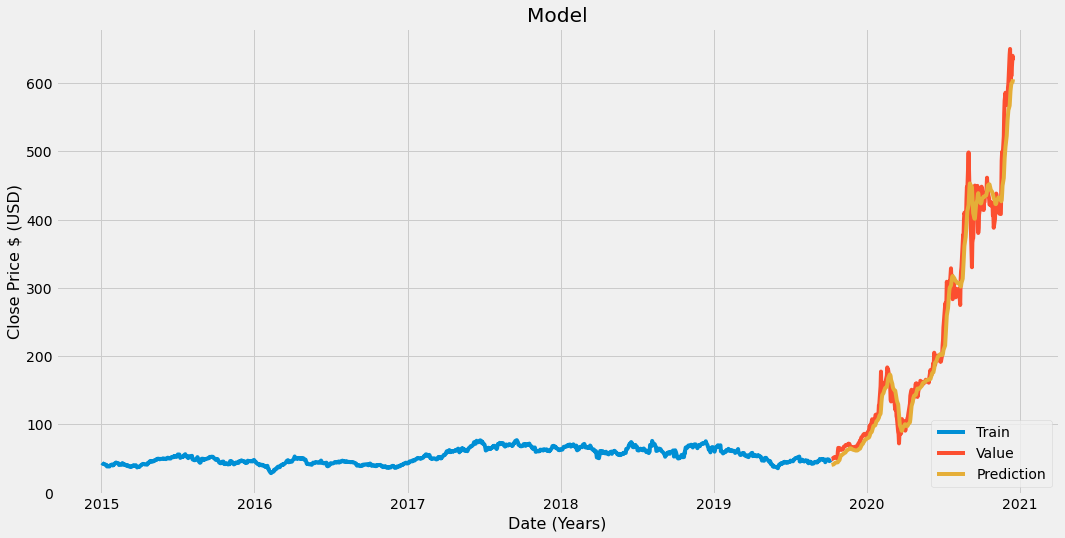

In [47]:
#Plot data
t = data[:training_data_len]
v = data[training_data_len:]
v['Prediction'] = prediction

#Show data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date (Years)', fontsize=16)
plt.ylabel('Close Price $ (USD)', fontsize=16)
plt.plot(t['Close'])
plt.plot(v[['Close', 'Prediction']])
plt.legend(['Train', 'Value', 'Prediction'], loc='lower right')
plt.show()

In [48]:
#Show acutal price vs predicted
v

,Close,Prediction
Date,,
2019-10-09,48.905998,40.776581
2019-10-10,48.948002,40.940075
2019-10-11,49.577999,41.177338
2019-10-14,51.391998,41.500011
2019-10-15,51.577999,42.049000
...,...,...
2020-12-09,604.479980,588.293579
2020-12-10,627.070007,594.179382
2020-12-11,609.989990,599.266785


In [49]:
#Predict next day closing stock price
#get quote
quote = web.DataReader('TSLA', data_source='yahoo', start='2015-01-01', end='2020-12-15')

#create new data frame
dataf2 = quote.filter(['Close'])

#Get last 60 day closing price values then convert dataframe to a array
last60d = dataf2[-60:].values
last60d_scaled = scaler.transform(last60d)

#Create empty list
Xtest = []
#append past 60 days
Xtest.append(last60d_scaled)

#convert xtest dataset to numpy array
Xtest = np.array(Xtest)
#reshape
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], 1))

#Get predicted scaled price
price_predicted = mdl.predict(Xtest)
#undo scaling
price_predicted = scaler.inverse_transform(price_predicted)

#show predicted price for next day
print("Predicted Price for next day")
print(price_predicted)

Predicted Price for next day
[[608.90204]]


In [50]:
#Show actual clsing price for enxt day
#get quote
actual = web.DataReader('TSLA', data_source='yahoo', start='2020-12-16', end='2020-12-16')
print(actual['Close'])

print('Price Predicted:', price_predicted)

Date
2020-12-16    622.77002
Name: Close, dtype: float64
Price Predicted: [[608.90204]]
